#### Importing all the necessary libraries

In [111]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split as ms_train_test_split
import warnings; warnings.simplefilter('ignore')
from surprise import KNNWithMeans
from scipy.sparse.linalg import svds
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split as s_train_test_split
from surprise import accuracy
from surprise import SVD
from collections import defaultdict
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

#### Read the data as a dataframe

In [2]:
df = pd.read_csv('ratings_Electronics.csv', names = ['user_id', 'product_id', 'ratings', 'timestamp'])

In [3]:
df.head()

,user_id,product_id,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


#### Checking the data types of the columns

In [4]:
df.dtypes

user_id        object
product_id     object
ratings       float64
timestamp       int64
dtype: object

#### Checking the information of the dataframe

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
user_id       object
product_id    object
ratings       float64
timestamp     int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


#### Checking the shape of the dataframe

In [6]:
df.shape

(7824482, 4)

In [7]:
# The dataframe has a huge number of records
# Check the number of rows and columnss
rows, columns = df.shape
print("No of rows: ", rows) 
print("No of columns: ", columns)

No of rows:  7824482
No of columns:  4


#### Checking the presence of null values in the dataframe

In [8]:
df.isnull().sum()

user_id       0
product_id    0
ratings       0
timestamp     0
dtype: int64

In [9]:
## Thankfully we have no null values in the dataframe and hence we don't require any sort of missiing value treatment.

#### Description of the numerical columns

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ratings,7824482.0,4.012337e+00,1.380910e+00,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
timestamp,7824482.0,1.338178e+09,6.900426e+07,912729600.0,1.315354e+09,1.361059e+09,1.386115e+09,1.406074e+09


#### Finding out the range of ratings

In [11]:
print('The minimum rating is: %d' %(df['ratings'].min()))
print('The maximum rating is: %d' %(df['ratings'].max()))

The minimum rating is: 1
The maximum rating is: 5


In [12]:
# Summary statistics of 'rating' variable
df['ratings'].describe().transpose()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: ratings, dtype: float64

#### Plotiing the distribution of the different ratings

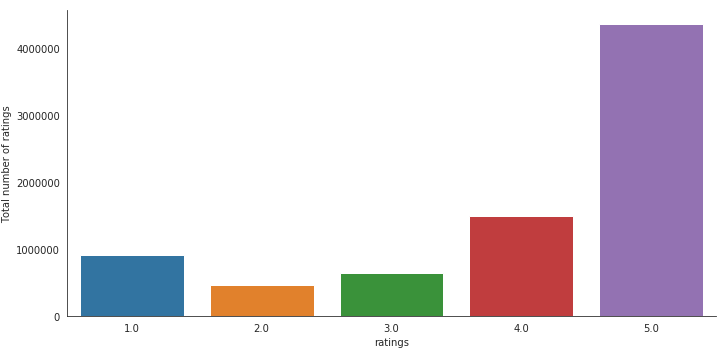

In [13]:
with sns.axes_style('white'):
    g = sns.factorplot("ratings", data=df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings") 

#### Ratings distribution

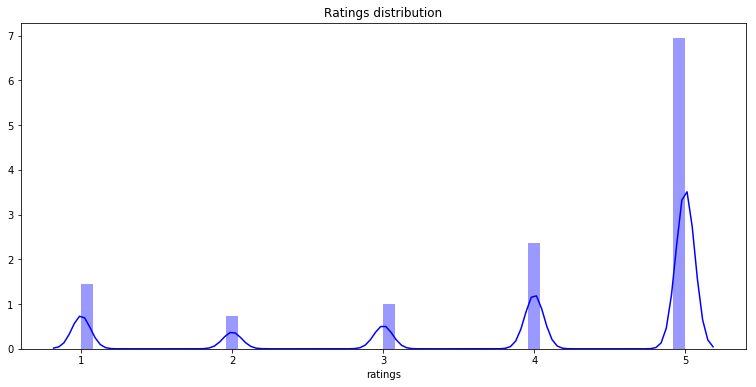

In [14]:
plt.figure(figsize=(13,6))
sns.distplot(df["ratings"],color="b")
plt.title("Ratings distribution")
plt.show()

In [15]:
df['ratings'].value_counts()

5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: ratings, dtype: int64

In [16]:
df['ratings'].value_counts(normalize = True)

5.0    0.555633
4.0    0.189889
1.0    0.115249
3.0    0.080909
2.0    0.058320
Name: ratings, dtype: float64

In [17]:
## We see that 5 has the highest population in the dataset. More than 55 percent of the records have rating of 5.

#### Let's find out the number of unique users and number of unique products in the dataset

In [18]:
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique PRODUCTS in Raw data = ', df['product_id'].nunique())

Number of unique USERS in Raw data =  4201696
Number of unique PRODUCTS in Raw data =  476002


#### Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 50 or more number of ratings)

In [19]:
# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

In [20]:
# Last 10 users based on rating
least_rated = df.groupby('user_id').size().sort_values(ascending = True)[:10]
least_rated

user_id
A00000262KYZUE4J55XGL    1
A3AAXWDYVQ93SZ           1
A3AAXWHVCN6VOG           1
A3AAXX0N47FFP            1
A3AAXY0TMZS72Y           1
A3AAXZAK8EB9KG           1
A3AAY0GAXS0XNA           1
A3AAY3OP8Z7FTA           1
A3AAY5WI5T8HN5           1
A3AAYE1Y83YT2P           1
dtype: int64

In [21]:
## We find that there are many users who have rated more than 200 products while there are users who have rated only 1 products.
# So here we see that the dataset is higly sparse, so let's try to make it denser by 
#considering only those users who have rated atleast 100 records

In [22]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 100].index)]

In [23]:
df_final.head()

,user_id,product_id,ratings,timestamp
118,AT09WGFUM934H,0594481813,3.0,1377907200
178,A17HMM1M7T9PJ1,0970407998,4.0,1281744000
631,A3TAS1AG6FMBQW,0972683275,5.0,1353456000
1777,A18S2VGUH9SCV5,1400501776,4.0,1340755200
2162,A5JLAU2ARJ0BO,1400532655,1.0,1291334400


#### Data model preparation as per requirement on number of minimum ratings

In [24]:
print('Number of users who have rated 50 or more items =', len(df_final))
print('Number of unique USERS in final data = ', df_final['user_id'].nunique())
print('Number of unique ITEMS in final data = ', df_final['product_id'].nunique())

Number of users who have rated 50 or more items = 44209
Number of unique USERS in final data =  289
Number of unique ITEMS in final data =  22635


#### df_final has users who have rated 100 or more items

In [25]:
df_final.shape

(44209, 4)

In [26]:
rows, columns = df_final.shape
print("No of rows in final dataset: ", rows) 
print("No of columnsin final dataset: ", columns)

No of rows in final dataset:  44209
No of columnsin final dataset:  4


#### Calculate the density of the rating matrix

In [27]:
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='product_id', values = 'ratings').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (289, 22635)
given_num_of_ratings =  44209
possible_num_of_ratings =  6541515
density: 0.68%


In [28]:
final_ratings_matrix.head()

product_id,0594481813,0970407998,0972683275,1400501776,1400532655,1400599997,1400699169,1685560148,7562434166,787988002X,...,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L8I6SFY,B00LA6T0LS,B00LBZ1Z7K,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10PEXB6XAQ5XF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10Y058K7B96C6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10ZFE6YE0UHW8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Matrix with one row per 'Product' and one column per 'user' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

user_id,A100UD67AHFODS,A100WO06OQR8BQ,A10PEXB6XAQ5XF,A10Y058K7B96C6,A10ZFE6YE0UHW8,A11D1KHM7DVOQK,A11I1I9QLMAM1A,A11KZ906QD08C5,A12DQZKRKTNF5E,A1435P5AMCPB3X,...,AVPNQUVZWMDSX,AWNJAY0M5UI70,AWPODHOB4GFWL,AX05DBU8IRUWY,AX7317G153T8W,AY6A8KPYCE6B0,AYB4ELCS5AM8P,AZ515FFZ7I2P7,AZAC8O310IK4E,AZMY6E8B52L2T
product_id,,,,,,,,,,,,,,,,,,,,,
0594481813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0970407998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0972683275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400532655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Splitting data into training and test set

In [30]:
#Split the data randomnly into test and train datasets
#Split the training and test data in the ratio 70:30
train_data, test_data = ms_train_test_split(df_final, test_size = 0.3, random_state=0)
train_data.head()

,user_id,product_id,ratings,timestamp
5537142,AN81JUYW2SL24,B006ZW4H4C,5.0,1360540800
3066468,AEWYUPCNDV7HY,B0035FZ124,5.0,1288656000
1535041,A1U5IJHJK84S54,B000YNVSMW,3.0,1282176000
3310087,A1ZU55TM45Y2R8,B003ES4NIA,5.0,1274918400
1188838,AGOH8N902URMW,B000N29KOW,5.0,1179792000


## Build Popularity Recommender model 1. (Non-personalised)

In [31]:
#Highest rated products considering mean ratings of individual products
df_final.groupby('product_id')['ratings'].mean().sort_values(ascending=False).head()  

product_id
B00LKG1MC8    5.0
B004MSMCSO    5.0
B004MS8QQ6    5.0
B004MS0DIK    5.0
B000NMFCIA    5.0
Name: ratings, dtype: float64

In [32]:
#Products rated by most number of users
df_final.groupby('product_id')['ratings'].count().sort_values(ascending=False).head()  

product_id
B0088CJT4U    74
B002R5AM7C    60
B003ES5ZUU    55
B00829TIEK    52
B004CLYEDC    50
Name: ratings, dtype: int64

In [33]:
ratings_mean_count = pd.DataFrame(df_final.groupby('product_id')['ratings'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(df_final.groupby('product_id')['ratings'].count())  

#### The following dataframe shows ratings of the individual products and the number of persons who rated that product

In [34]:
ratings_mean_count.head()

,ratings,rating_counts
product_id,,
0594481813,3.0,1
0970407998,4.0,1
0972683275,5.0,1
1400501776,4.0,1
1400532655,2.0,2


In [35]:
ratings_mean_count.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22635 entries, 0594481813 to B00LKG1MC8
Data columns (total 2 columns):
ratings          22635 non-null float64
rating_counts    22635 non-null int64
dtypes: float64(1), int64(1)
memory usage: 530.5+ KB


In [36]:
# Here we see that there are many products which got only one rating but still at the top of list which
# should not be there in the ideal case. Hence, let's consider only those ratings which have a rating_count of greater than 5

In [37]:
filtered_mean_ratings = ratings_mean_count[ratings_mean_count['rating_counts'] >= 5]

In [38]:
filtered_mean_ratings.head()

,ratings,rating_counts
product_id,,
B00001P4XA,4.400000,5
B00001P4ZH,4.333333,6
B00001WRSJ,3.800000,5
B00003006E,5.000000,5
B00004RC2D,4.714286,7


In [39]:
filtered_mean_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1769 entries, B00001P4XA to B00LGQ6HL8
Data columns (total 2 columns):
ratings          1769 non-null float64
rating_counts    1769 non-null int64
dtypes: float64(1), int64(1)
memory usage: 41.5+ KB


## Top 5 Product Recommendations from Popularity Based Model 1

In [40]:
df_popularity_model1 = pd.DataFrame(filtered_mean_ratings.groupby('product_id')['ratings'].mean().sort_values(ascending=False).head(5))
df_popularity_model1

,ratings
product_id,
B00LGQ6HL8,5.0
B008RDI0TU,5.0
B00FDK99QS,5.0
B0007QKMQY,5.0
B002WE0QN8,5.0


In [41]:
def recommend1(user_id):     
    user_recommendations = df_popularity_model1 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userID'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [42]:
find_recom = [15,121,53]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend1(i))    
    print("\n") 

Here is the recommendation for the userId: 15

            userID  ratings
product_id                 
B00LGQ6HL8      15      5.0
B008RDI0TU      15      5.0
B00FDK99QS      15      5.0
B0007QKMQY      15      5.0
B002WE0QN8      15      5.0


Here is the recommendation for the userId: 121

            userID  ratings
product_id                 
B00LGQ6HL8     121      5.0
B008RDI0TU     121      5.0
B00FDK99QS     121      5.0
B0007QKMQY     121      5.0
B002WE0QN8     121      5.0


Here is the recommendation for the userId: 53

            userID  ratings
product_id                 
B00LGQ6HL8      53      5.0
B008RDI0TU      53      5.0
B00FDK99QS      53      5.0
B0007QKMQY      53      5.0
B002WE0QN8      53      5.0




## Building Popularity Based Model 2

In [43]:
#Count of user_id for each unique product as recommendation score 
df_final_grouped = df_final.groupby('product_id').agg({'user_id': 'count'}).reset_index()
df_final_grouped.rename(columns = {'user_id': 'score'},inplace=True)
df_final_grouped.head(10)

,product_id,score
0,0594481813,1
1,0970407998,1
2,0972683275,1
3,1400501776,1
4,1400532655,2
5,1400599997,1
6,1400699169,1
7,1685560148,1
8,7562434166,1
9,787988002X,1


#### Top 5 Recommendations based Popularity Based Recommender Model 2

In [44]:
#Sort the products on recommendation score
df_final_sort = df_final_grouped.sort_values(['score', 'product_id'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
df_final_sort['Rank'] = df_final_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = df_final_sort.head(5) 
popularity_recommendations

,product_id,score,Rank
18128,B0088CJT4U,74,1.0
10846,B002R5AM7C,60,2.0
12083,B003ES5ZUU,55,3.0
17985,B00829TIEK,52,4.0
13773,B004CLYEDC,50,5.0


In [45]:
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userID'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [46]:
find_recom = [15,121,53]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: 15

       userID  product_id  score  Rank
18128      15  B0088CJT4U     74   1.0
10846      15  B002R5AM7C     60   2.0
12083      15  B003ES5ZUU     55   3.0
17985      15  B00829TIEK     52   4.0
13773      15  B004CLYEDC     50   5.0


Here is the recommendation for the userId: 121

       userID  product_id  score  Rank
18128     121  B0088CJT4U     74   1.0
10846     121  B002R5AM7C     60   2.0
12083     121  B003ES5ZUU     55   3.0
17985     121  B00829TIEK     52   4.0
13773     121  B004CLYEDC     50   5.0


Here is the recommendation for the userId: 53

       userID  product_id  score  Rank
18128      53  B0088CJT4U     74   1.0
10846      53  B002R5AM7C     60   2.0
12083      53  B003ES5ZUU     55   3.0
17985      53  B00829TIEK     52   4.0
13773      53  B004CLYEDC     50   5.0




Since this is a popularity-based recommender model, recommendations remain the same for all users

We predict the products based on the popularity. It is not personalized to particular user

#### So in this second method of Popularity Based Model we gave importance to the number of ratings received by the products.
#### In this approach Products receiving the maximum rating are treated as more popular than the ratings they have got.
#### According to me, Popularity Based Recommender Model 1 will be more effective since we considered both raings as well as count of ratings each product received.


## Building Collaborative Filtering Model

In [47]:
pivot_df = df_final.pivot(index = 'user_id', columns ='product_id', values = 'ratings').fillna(0)
print(pivot_df.shape)
pivot_df.head()

(289, 22635)


product_id,0594481813,0970407998,0972683275,1400501776,1400532655,1400599997,1400699169,1685560148,7562434166,787988002X,...,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L8I6SFY,B00LA6T0LS,B00LBZ1Z7K,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10PEXB6XAQ5XF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10Y058K7B96C6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10ZFE6YE0UHW8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

product_id,0594481813,0970407998,0972683275,1400501776,1400532655,1400599997,1400699169,1685560148,7562434166,787988002X,...,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L8I6SFY,B00LA6T0LS,B00LBZ1Z7K,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_index
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A10PEXB6XAQ5XF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A10Y058K7B96C6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10ZFE6YE0UHW8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [49]:
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

product_id,0594481813,0970407998,0972683275,1400501776,1400532655,1400599997,1400699169,1685560148,7562434166,787988002X,...,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L8I6SFY,B00LA6T0LS,B00LBZ1Z7K,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### SVD is best to apply on a large sparse matrix. Hence we will use it here.

In [50]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [51]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

product_id,0594481813,0970407998,0972683275,1400501776,1400532655,1400599997,1400699169,1685560148,7562434166,787988002X,...,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L8I6SFY,B00LA6T0LS,B00LBZ1Z7K,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.004376,0.001057,0.004161,0.001726,0.004825,0.000194,0.017578,0.009128,0.001966,0.002814,...,0.044277,0.333528,-0.000390,-0.008040,0.059227,0.086071,-0.006778,0.140664,0.072311,0.022799
1,0.003667,0.008384,0.029385,0.015703,-0.004602,0.000366,0.024532,0.009325,0.001859,0.015246,...,-0.019240,0.172144,0.015216,0.038608,0.034060,-0.008770,0.018240,-0.025528,-0.017451,0.006688
2,0.003137,0.003995,0.024677,0.011827,-0.001617,0.000196,0.025942,0.008179,0.001592,0.011904,...,-0.009984,0.237399,0.012950,0.028121,0.034888,-0.000079,0.016353,-0.012854,-0.003310,0.008004
3,0.000404,0.014348,0.054795,0.028561,0.001552,0.000493,0.023471,0.004463,0.000555,0.024806,...,-0.056389,0.229455,0.037794,0.083599,0.025563,-0.071602,0.059349,-0.041721,-0.055347,-0.009855
4,0.005866,0.009150,0.022547,0.010896,0.003353,0.000406,0.025530,0.012655,0.002587,0.012838,...,0.031246,0.317201,0.011743,0.024374,0.081484,0.081634,0.009393,0.143562,0.058537,0.022167


In [52]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [53]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 12
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 12):

                   user_ratings  user_predictions
Recommended Items                                
B0088CJT4U                  0.0          1.418499
B00829TIEK                  0.0          1.048077
B008DWCRQW                  0.0          0.903860
B00829THK0                  0.0          0.885811
B004CLYEFK                  0.0          0.880335


In [54]:
# Actual ratings given by the users
final_ratings_matrix.head()

product_id,0594481813,0970407998,0972683275,1400501776,1400532655,1400599997,1400699169,1685560148,7562434166,787988002X,...,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L8I6SFY,B00LA6T0LS,B00LBZ1Z7K,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10PEXB6XAQ5XF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10Y058K7B96C6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10ZFE6YE0UHW8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

product_id
0594481813    0.010381
0970407998    0.013841
0972683275    0.017301
1400501776    0.013841
1400532655    0.013841
dtype: float64

In [56]:
# Predicted ratings 
preds_df.head()

product_id,0594481813,0970407998,0972683275,1400501776,1400532655,1400599997,1400699169,1685560148,7562434166,787988002X,...,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L8I6SFY,B00LA6T0LS,B00LBZ1Z7K,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.004376,0.001057,0.004161,0.001726,0.004825,0.000194,0.017578,0.009128,0.001966,0.002814,...,0.044277,0.333528,-0.000390,-0.008040,0.059227,0.086071,-0.006778,0.140664,0.072311,0.022799
1,0.003667,0.008384,0.029385,0.015703,-0.004602,0.000366,0.024532,0.009325,0.001859,0.015246,...,-0.019240,0.172144,0.015216,0.038608,0.034060,-0.008770,0.018240,-0.025528,-0.017451,0.006688
2,0.003137,0.003995,0.024677,0.011827,-0.001617,0.000196,0.025942,0.008179,0.001592,0.011904,...,-0.009984,0.237399,0.012950,0.028121,0.034888,-0.000079,0.016353,-0.012854,-0.003310,0.008004
3,0.000404,0.014348,0.054795,0.028561,0.001552,0.000493,0.023471,0.004463,0.000555,0.024806,...,-0.056389,0.229455,0.037794,0.083599,0.025563,-0.071602,0.059349,-0.041721,-0.055347,-0.009855
4,0.005866,0.009150,0.022547,0.010896,0.003353,0.000406,0.025530,0.012655,0.002587,0.012838,...,0.031246,0.317201,0.011743,0.024374,0.081484,0.081634,0.009393,0.143562,0.058537,0.022167


In [57]:
preds_df.mean().head()

product_id
0594481813    0.003668
0970407998    0.007692
0972683275    0.022440
1400501776    0.012313
1400532655    0.007726
dtype: float64

In [58]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(22635, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
product_id,,,
0594481813,0.010381,0.003668,0
0970407998,0.013841,0.007692,1
0972683275,0.017301,0.022440,2
1400501776,0.013841,0.012313,3
1400532655,0.013841,0.007726,4


#### RMSE of the Collaborative Filtering

In [59]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.01085 



#### Fetching the top 5 Recommendations for a User

In [92]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 20
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 20):

                   user_ratings  user_predictions
Recommended Items                                
B00829TIEK                  0.0          1.222972
B004CLYEDC                  0.0          1.133569
B000N99BBC                  0.0          1.065918
B004CLYEFK                  0.0          0.964931
B00829THK0                  0.0          0.953988


###### This involved a lot of calculations from our end, let's try to implement the same using scikit-surprise library specially designed for Recommendation Systems

### Collaborative Filtering using Surprise Library

In [60]:
surprise_df = df_final.drop('timestamp', axis = 1)

In [61]:
surprise_df.head()

,user_id,product_id,ratings
118,AT09WGFUM934H,0594481813,3.0
178,A17HMM1M7T9PJ1,0970407998,4.0
631,A3TAS1AG6FMBQW,0972683275,5.0
1777,A18S2VGUH9SCV5,1400501776,4.0
2162,A5JLAU2ARJ0BO,1400532655,1.0


In [ ]:
#To use external dataset with surprise, we must use the Reader and rating scale as per our dataset

In [63]:
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(surprise_df[['user_id', 'product_id', 'ratings']], reader)

In [ ]:
# Splitting data into training and test set

In [64]:
trainset, testset = s_train_test_split(data, test_size= 0.3)

#### We will use SVD for this purpose since it's a large sparse matrix

In [96]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = SVD()
algo.fit(trainset)

In [67]:
uid = 22
iid = 302

In [68]:
# get a prediction for specific users and items.
pred = algo.predict(uid, iid, verbose=True)

user: 22         item: 302        r_ui = None   est = 4.28   {'was_impossible': False}


In [69]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [70]:
test_pred

[Prediction(uid='A1UQBFCERIP7VJ', iid='B00BWJW7UO', r_ui=5.0, est=4.323787008587908, details={'was_impossible': False}),
 Prediction(uid='A3V7D0LH8L7BG0', iid='B005UI6V1E', r_ui=5.0, est=4.373920476938093, details={'was_impossible': False}),
 Prediction(uid='AVPNQUVZWMDSX', iid='B001LYX3MQ', r_ui=1.0, est=4.330987085990897, details={'was_impossible': False}),
 Prediction(uid='A34BZM6S9L7QI4', iid='B002BNMPCU', r_ui=5.0, est=4.511343751710429, details={'was_impossible': False}),
 Prediction(uid='A353U0L2HAMSHV', iid='B0079UAT0A', r_ui=5.0, est=4.477326342666223, details={'was_impossible': False}),
 Prediction(uid='A2AF0NOCM71J0B', iid='B00A311LUE', r_ui=5.0, est=4.272269891499231, details={'was_impossible': False}),
 Prediction(uid='A680RUE1FDO8B', iid='B008R7EWEI', r_ui=5.0, est=4.576733549985334, details={'was_impossible': False}),
 Prediction(uid='A2NB2E5DXE319Z', iid='B004HD4L1U', r_ui=5.0, est=4.275827483729956, details={'was_impossible': False}),
 Prediction(uid='A22MANL4US4RMY', 

#### Accuracy of the model

In [71]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 0.9622


0.9622320895285807

In [94]:
accuracy.mae(test_pred, verbose=True)

MAE:  0.7128


0.7127818888413442

In [99]:
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9390  0.9510  0.9436  0.9545  0.9691  0.9514  0.0104  
MAE (testset)     0.6997  0.7049  0.7048  0.7111  0.7163  0.7074  0.0057  
Fit time          3.02    3.30    3.44    3.15    3.01    3.18    0.16    
Test time         0.07    0.08    0.08    0.08    0.07    0.07    0.00    


{'test_rmse': array([0.93899328, 0.95099994, 0.94358744, 0.95451829, 0.96909687]),
 'test_mae': array([0.69972976, 0.70490075, 0.704842  , 0.71106088, 0.71633515]),
 'fit_time': (3.0162882804870605,
  3.3000574111938477,
  3.436058759689331,
  3.1462817192077637,
  3.0138161182403564),
 'test_time': (0.06800436973571777,
  0.07598137855529785,
  0.07998204231262207,
  0.07597875595092773,
  0.06828665733337402)}

#### Using GriSearch CV to tune the hyperparameters to enhance model performance further

In [104]:
param_grid = {'n_factors': [80, 100, 120], 'n_epochs': [10, 20, 50], 'lr_all': [0.003, 0.005, 0.008, 0.01],
              'reg_all': [0.1, 0.15, 0.2]}

In [105]:
svd_gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=2)
svd_gs.fit(data)

In [107]:
print(svd_gs.best_score['rmse'])
print(svd_gs.best_params['rmse'])

0.9504163324649815
{'n_factors': 80, 'n_epochs': 50, 'lr_all': 0.005, 'reg_all': 0.15}


In [108]:
# Since there is not much difference in accuracy with GridSearch we are sticking to the original algo itself

In [79]:
def get_top_n(predictions, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [80]:
top_n = get_top_n(test_pred, n=5)

In [81]:
top_n

defaultdict(list,
            {'A1UQBFCERIP7VJ': [('B0082E9K7U', 4.935993288117457),
              ('B0079UAT0A', 4.875364199009269),
              ('B00G4UQ6U8', 4.872863261817327),
              ('B00G4V0QSK', 4.867915242804363),
              ('B00DW374W4', 4.8457097097901505)],
             'A3V7D0LH8L7BG0': [('B0025VKUQQ', 4.818448978701198),
              ('B00139JBU2', 4.630502467077231),
              ('B000CKVOOY', 4.6286848005745584),
              ('B000QWEN5K', 4.599315509728915),
              ('B00HNJWVO4', 4.598060179556752)],
             'AVPNQUVZWMDSX': [('B007WTAJTO', 4.773935154982454),
              ('B002TOJXIA', 4.526008609086338),
              ('B002FB7IX4', 4.504988651057428),
              ('B00IVPU6AA', 4.503407085637696),
              ('B0019RBJOE', 4.468013258173516)],
             'A34BZM6S9L7QI4': [('B00HNJWSH4', 4.940560574526696),
              ('B007WTAJTO', 4.908505201118784),
              ('B00ENZRS76', 4.856490862478413),
              ('B00G4V0Q

#### Printing Top 5 Recommendations for each user

In [82]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A1UQBFCERIP7VJ ['B0082E9K7U', 'B0079UAT0A', 'B00G4UQ6U8', 'B00G4V0QSK', 'B00DW374W4']
A3V7D0LH8L7BG0 ['B0025VKUQQ', 'B00139JBU2', 'B000CKVOOY', 'B000QWEN5K', 'B00HNJWVO4']
AVPNQUVZWMDSX ['B007WTAJTO', 'B002TOJXIA', 'B002FB7IX4', 'B00IVPU6AA', 'B0019RBJOE']
A34BZM6S9L7QI4 ['B00HNJWSH4', 'B007WTAJTO', 'B00ENZRS76', 'B00G4V0QSK', 'B008ULPAT2']
A353U0L2HAMSHV ['B0079UAT0A', 'B001TOD7ME', 'B000S5Q9CA', 'B002FECHQ4', 'B000FOYMKU']
A2AF0NOCM71J0B ['B007WTAJTO', 'B00609B3J2', 'B008RJZQSW', 'B004TLH6H6', 'B00BQ4F9ZA']
A680RUE1FDO8B ['B001I45T9O', 'B00I6CVPVC', 'B005JW6WQU', 'B001S0PWWC', 'B00DIOALPE']
A2NB2E5DXE319Z ['B002WE6D44', 'B00GBATPFO', 'B007WTAJTO', 'B0052SCU8U', 'B00313JWSO']
A22MANL4US4RMY ['B002V88HFE', 'B00017LSPI', 'B002OOWC8I', 'B00425GCTC', 'B004AFFZNI']
A36K2N527TXXJN ['B000HPV3RW', 'B00003006E', 'B001TH7GVE', 'B001TH7GSW', 'B00HZVPD72']
A1IU7S4HCK1XK0 ['B008EWNVI4', 'B00DOWCQB2', 'B00428N9N6', 'B002KETE24', 'B000PTFDYO']
AOEAD7DPLZE53 ['B002YV569I', 'B0041Q38NU', 'B000028F42',

#### So we come to this conclusion that Popularity Based Recommendation is effective when we have no user preference available, but once it is available, Collaborative filtering is more useful since this is personalized and provides content as per the user's taste.